In [11]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
import zipfile as zipfile


In [12]:
#importing the required modules
zip_file_path = './data/processed/movielens1m_natural_noise_ratings.zip'
csv_file_name = 'movielens1m_natural_noise_ratings.csv'

# Extract the CSV file from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name, './data/processed')  # Specify the path to extract the CSV file

In [13]:
# Load Data
ml1m_dir = "./data/processed/movielens1m_natural_noise_ratings.csv"
ml1m_rating = pd.read_csv(ml1m_dir, sep=',',  engine='python')
df = ml1m_rating

In [14]:
## Code below is the same as per time_weighted_movielens1m.ipynb
# This code basically conducts time weighting of ratings after the filter of natural noise out of the ratings

In [19]:
#Function to find the number of days between 2 dates
def days_difference(date1, date2):

    # Convert string dates to datetime objects
    date1 = datetime.strptime(date1, '%d/%m/%Y')
    date2 = datetime.strptime(date2, '%d/%m/%Y')

    # Calculate the difference in days
    difference = -(date2 - date1).days

    return difference

# Function to convert number of days to years
def days_to_year(days):
  return days/365

## A basic logistic function - Used later to help derive time-decayed ratings
def logistic(tu_c):
    exponent = -tu_c
    denominator = 1 + math.exp(exponent)
    result = 1 / denominator
    return result

In [20]:
# Defining a couple of required dates to help derive time-weighted ratings
# Purpose explained in future paragraphs below
max_review_date = df['date'].max()
min_review_date = df['date'].min()

date_max = datetime.strptime(max_review_date, "%d/%m/%Y")
date_min = datetime.strptime(min_review_date, "%d/%m/%Y")

midpoint_date = (date_min + (date_max - date_min) / 2).strftime("%d/%m/%Y")
diff_max_midpoint = days_to_year(days_difference(max_review_date,midpoint_date))
diff_min_midpoint = days_to_year(days_difference(min_review_date,midpoint_date))

In [21]:
#Finding the "maximum"/latest date among all Movielens reviews
max_review_date

# date_max - Converts max_review_date to datetime format

'9/9/2002'

In [22]:
#Finding the "minimum"/earliest date among all Movielens reviews
min_review_date

# date_min - Converts min_review_date to datetime format

'1/1/2001'

In [23]:
#Find the middle date between max_review_date and min_review_date
midpoint_date

'05/11/2001'

In [24]:
#Find the days difference between the maximum date and the midpoint date
diff_max_midpoint

0.8438356164383561

In [25]:
#Find the days difference between the minimum date and the midpoint date
diff_min_midpoint

-0.8438356164383561

In [26]:
#Function to help normalise the time(in years) of each rating from the midpoint_date
#to the range [-1,1]
#Used to transform the years from middle date into input into the logistic function
def normalised(year,max_range_to_set=1,min_range_to_set=-1):
  max = diff_max_midpoint
  min = diff_min_midpoint
  normalised_value = (  (max_range_to_set-min_range_to_set)*((year-min)/(max-min))  )  + min_range_to_set
  return normalised_value


In [27]:
# For each rating, find out the years this particular rating is rated from the midpoint_date
df['years_from_midpoint'] = df.apply(lambda row: days_to_year(days_difference(row['date'],midpoint_date)),axis=1)

# Normalised the years from midpoint date to a range [-1,1]
df["normalised_year_from_midpoint"] =  df.apply(lambda row: normalised(row['years_from_midpoint']),axis=1)

# Calculate the time weight of the ratings
df['time_weight'] = df.apply(lambda row: logistic(row['normalised_year_from_midpoint']),axis=1)

# Weigh the ratings by its time weight to derive the time-weighted ratings
df['time_weighted_rating'] = df['time_weight']*df['rating']

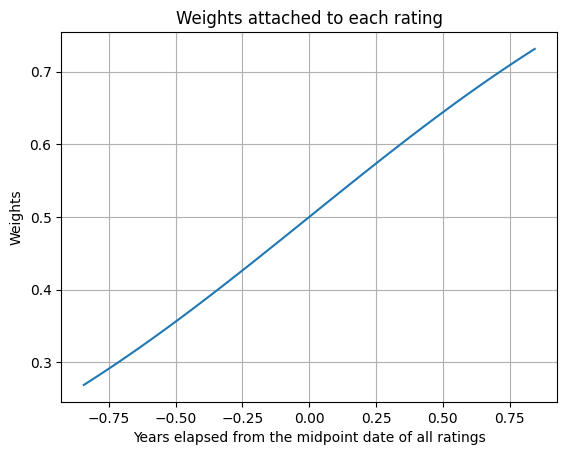

<Figure size 640x480 with 0 Axes>

In [29]:
tu_c_values = np.linspace(diff_min_midpoint, diff_max_midpoint, 100)

normalised_values = [normalised(tu_c) for tu_c in tu_c_values]
# Calculate logistic function for each tu_c value
logistic_values = [logistic(n_v) for n_v in normalised_values]

# Plot the logistic function that is normalised for better understanding
plt.plot(tu_c_values, logistic_values)
plt.title('Weights attached to each rating')
plt.xlabel('Years elapsed from the midpoint date of all ratings')
plt.ylabel('Weights')
plt.grid(True)
plt.show()

#Save figure and data
plt.savefig('natural_noise_time_weighted_rating_movielens1m.png')
df.to_csv('./data/processed/natural_noise_time_weighted_rating_movielens1m.csv', index=False)